## COVID-19 Country Model ##

###### Packages #####

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
#check the old format
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])

### Cleaning Data

In [3]:
# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')

In [4]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]


In [5]:
country = 'India'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed,Deaths,Recovered
Date,,,
2020-04-19,17615,559,2854
2020-04-20,18539,592,3273
2020-04-21,20080,645,3975
2020-04-22,21370,681,4370
2020-04-23,23077,721,5012
2020-04-24,24530,780,5498
2020-04-25,26283,825,5939
2020-04-26,27890,881,6523
2020-04-27,29451,939,7137


# Prediction Models

__Diffusion Process (With Gradient Descent)__

In [6]:
import math

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [7]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
    return math.sqrt(r) 

We need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize,

__Build Model__

In [8]:
import numpy as np
from scipy.optimize import minimize
def display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#999900FF', '#FF0000FF', '#0000FFFF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)

def display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#999900FF', '#FF0000FF', '#0000FFFF']

    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)


def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([country, *opt_confirmed, *opt_deaths, *opt_recovered])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax2)
        plt.show()

# Predict by Specify Country

United Arab Emirates COVID-19 Prediction


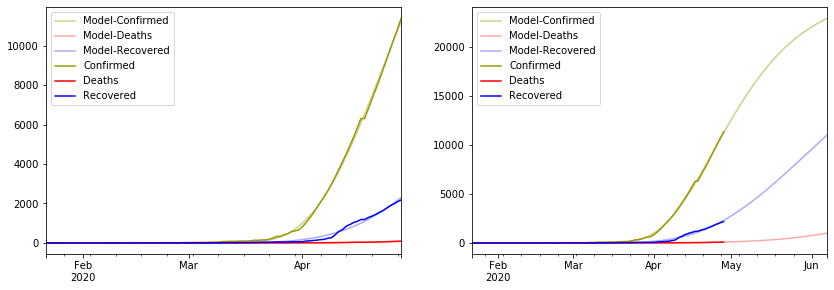

Saudi Arabia COVID-19 Prediction


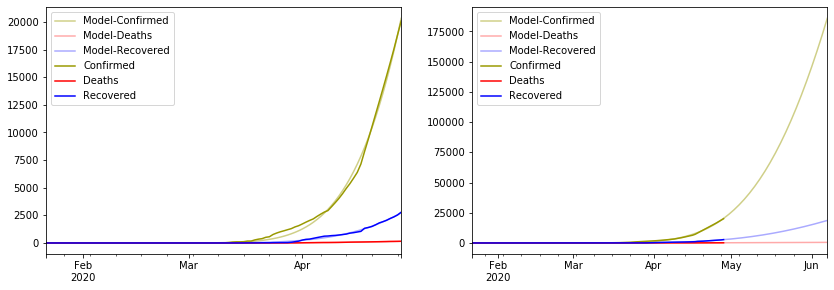

India COVID-19 Prediction


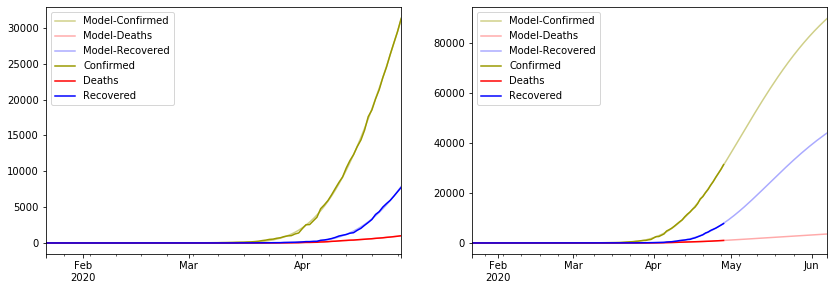

Iran COVID-19 Prediction


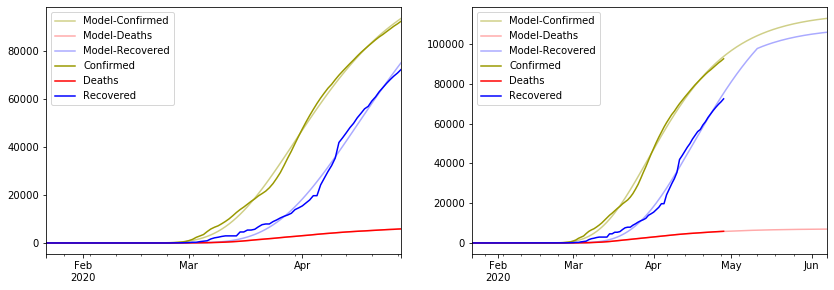

Bangladesh COVID-19 Prediction


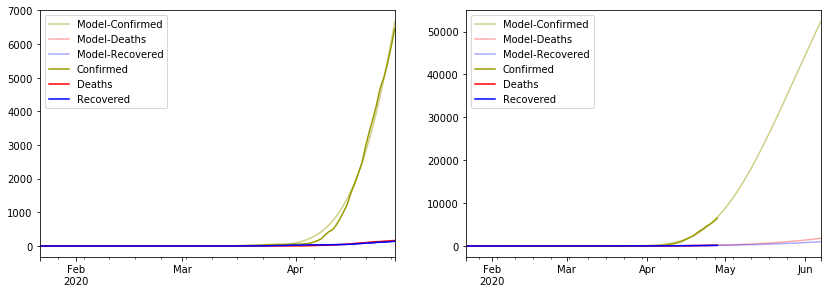

Malaysia COVID-19 Prediction


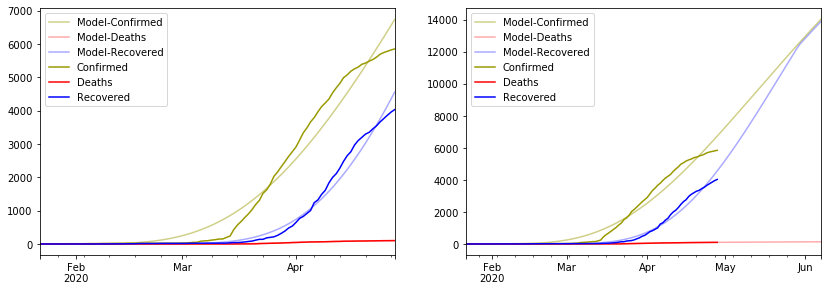

Indonesia COVID-19 Prediction


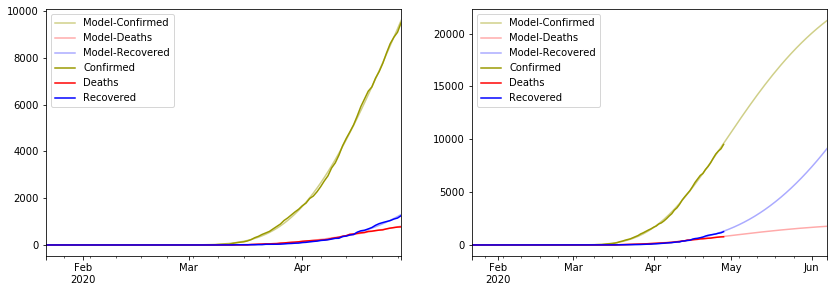

Turkey COVID-19 Prediction


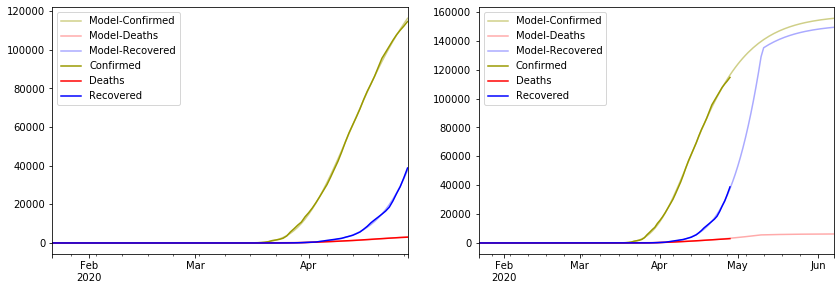

Pakistan COVID-19 Prediction


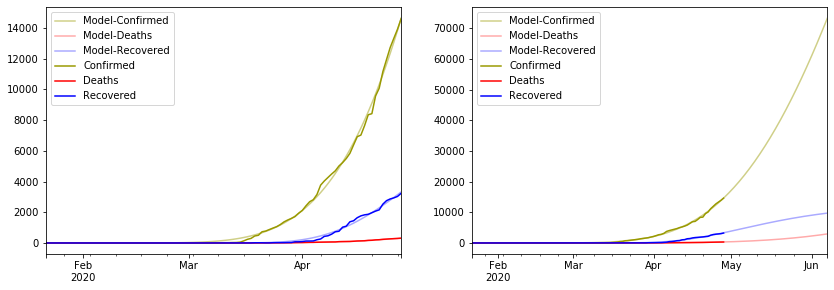

In [9]:
# Country Specify
stats = []
for country in ['United Arab Emirates','Saudi Arabia','India','Iran','Bangladesh','Malaysia','Indonesia','Turkey','Pakistan']:
# for country in ['Sweden']:
    df = get_time_series(country)

    print('{} COVID-19 Prediction'.format(country))
    
    opt_display_model(df, stats)

In [10]:
import datetime
import numpy as np
from scipy.optimize import minimize

def display_extended_table_pr(df):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)    
                                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
    
    return extended_model_sim

In [11]:
country = 'United Arab Emirates'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('UAE')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

UAE COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"2,659",12,239,"2,641",14,409
2020-04-10,"3,360",16,418,"3,290",17,510
2020-04-12,"4,123",22,680,"4,011",21,629
2020-04-14,"4,933",28,933,"4,798",26,765
2020-04-16,"5,825",35,"1,095","5,639",32,921
2020-04-18,"6,302",37,"1,188","6,525",38,"1,098"
2020-04-20,"7,265",43,"1,360","7,443",45,"1,296"
2020-04-22,"8,238",52,"1,546","8,384",54,"1,515"
2020-04-24,"9,281",64,"1,760","9,335",64,"1,757"
2020-04-26,"10,349",76,"1,978","10,286",75,"2,020"


In [12]:
country = 'Iran'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Iran')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Iran COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"64,586","3,993","29,812","62,486","4,006","31,667"
2020-04-10,"68,192","4,232","35,465","66,544","4,250","35,928"
2020-04-12,"71,686","4,474","43,894","70,408","4,479","40,312"
2020-04-14,"74,877","4,683","48,129","74,067","4,693","44,778"
2020-04-16,"77,995","4,869","52,229","77,513","4,892","49,285"
2020-04-18,"80,868","5,031","55,987","80,742","5,077","53,793"
2020-04-20,"83,505","5,209","59,273","83,756","5,247","58,268"
2020-04-22,"85,996","5,391","63,113","86,557","5,404","62,678"
2020-04-24,"88,194","5,574","66,599","89,153","5,547","66,998"
2020-04-26,"90,481","5,710","69,657","91,550","5,678","71,202"


In [13]:
country = 'India'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('India')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

India COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"5,916",178,506,"5,811",198,462
2020-04-10,"7,598",246,774,"7,371",246,693
2020-04-12,"9,205",331,"1,080","9,172",301,"1,006"
2020-04-14,"11,487",393,"1,359","11,213",364,"1,415"
2020-04-16,"13,430",448,"1,768","13,489",434,"1,935"
2020-04-18,"15,722",521,"2,463","15,988",511,"2,578"
2020-04-20,"18,539",592,"3,273","18,694",596,"3,355"
2020-04-22,"21,370",681,"4,370","21,587",688,"4,272"
2020-04-24,"24,530",780,"5,498","24,644",787,"5,332"
2020-04-26,"27,890",881,"6,523","27,840",893,"6,535"


In [14]:
country = 'Saudi Arabia'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Saudi Arabia')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Saudi Arabia COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"2,932",41,631,"3,037",41,519
2020-04-10,"3,651",47,685,"3,810",49,633
2020-04-12,"4,462",59,761,"4,735",58,765
2020-04-14,"5,369",73,889,"5,833",67,918
2020-04-16,"6,380",83,990,"7,126",78,"1,093"
2020-04-18,"8,274",92,"1,329","8,637",89,"1,293"
2020-04-20,"10,484",103,"1,490","10,390",101,"1,519"
2020-04-22,"12,772",114,"1,812","12,409",114,"1,773"
2020-04-24,"15,102",127,"2,049","14,721",127,"2,058"
2020-04-26,"17,522",139,"2,357","17,350",141,"2,375"


In [15]:
country = 'Bangladesh'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Bangladesh')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Bangladesh COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,218,20,33,430,25,32
2020-04-10,424,27,33,623,32,37
2020-04-12,621,34,39,878,40,44
2020-04-14,"1,012",46,42,"1,210",49,52
2020-04-16,"1,572",60,49,"1,630",60,60
2020-04-18,"2,144",84,66,"2,153",73,70
2020-04-20,"2,948",101,85,"2,789",88,81
2020-04-22,"3,772",120,92,"3,551",106,93
2020-04-24,"4,689",131,112,"4,448",126,107
2020-04-26,"5,416",145,122,"5,487",150,122


In [16]:
country = 'Malaysia'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Malaysia')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Malaysia COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"4,119",65,"1,487","3,480",65,"1,356"
2020-04-10,"4,346",70,"1,830","3,769",70,"1,579"
2020-04-12,"4,683",76,"2,108","4,068",75,"1,825"
2020-04-14,"4,987",82,"2,478","4,376",80,"2,093"
2020-04-16,"5,182",84,"2,766","4,693",84,"2,382"
2020-04-18,"5,305",88,"3,102","5,017",88,"2,694"
2020-04-20,"5,425",89,"3,295","5,349",92,"3,027"
2020-04-22,"5,532",93,"3,452","5,687",95,"3,381"
2020-04-24,"5,691",96,"3,663","6,032",98,"3,755"
2020-04-26,"5,780",98,"3,862","6,382",101,"4,148"


In [17]:
country = 'Indonesia'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Indonesia')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Indonesia COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"2,956",240,222,"3,131",280,243
2020-04-10,"3,512",306,282,"3,651",325,296
2020-04-12,"4,241",373,359,"4,210",372,359
2020-04-14,"4,839",459,426,"4,805",421,432
2020-04-16,"5,516",496,548,"5,431",472,516
2020-04-18,"6,248",535,631,"6,084",526,611
2020-04-20,"6,760",590,747,"6,760",580,720
2020-04-22,"7,418",635,913,"7,455",635,842
2020-04-24,"8,211",689,"1,002","8,164",691,979
2020-04-26,"8,882",743,"1,107","8,883",747,"1,132"


In [18]:
country = 'Turkey'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Turkey')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Turkey COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"38,226",812,"1,846","39,329",796,"1,581"
2020-04-10,"47,029","1,006","2,423","47,816",952,"2,360"
2020-04-12,"56,956","1,198","3,446","56,557","1,128","3,447"
2020-04-14,"65,111","1,403","4,799","65,334","1,324","4,933"
2020-04-16,"74,193","1,643","7,089","73,957","1,540","6,925"
2020-04-18,"82,329","1,890","10,453","82,271","1,776","9,547"
2020-04-20,"90,980","2,140","13,430","90,159","2,033","12,942"
2020-04-22,"98,674","2,376","16,477","97,540","2,309","17,266"
2020-04-24,"104,912","2,600","21,737","104,364","2,606","22,690"
2020-04-26,"110,130","2,805","29,140","110,610","2,921","29,400"


In [19]:
country = 'Pakistan'
df = get_time_series(country)
print('{} COVID-19 Prediction'.format('Pakistan')) 

cnt = display_extended_table_pr(df)
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, cnt], axis=1)
concat_df[concat_df.index.day % 2 == 0].tail(30)

Pakistan COVID-19 Prediction


,Confirmed,Deaths,Recovered,Model-Confirmed,Model-Deaths,Model-Recovered
2020-04-08,"4,263",61,467,"3,865",60,600
2020-04-10,"4,695",66,727,"4,522",73,765
2020-04-12,"5,230",91,"1,028","5,259",88,956
2020-04-14,"5,837",96,"1,378","6,080",106,"1,173"
2020-04-16,"6,919",128,"1,645","6,992",126,"1,416"
2020-04-18,"7,638",143,"1,832","7,999",150,"1,684"
2020-04-20,"8,418",176,"1,970","9,106",177,"1,975"
2020-04-22,"10,076",212,"2,156","10,318",207,"2,287"
2020-04-24,"11,940",253,"2,755","11,639",242,"2,617"
2020-04-26,"13,328",281,"2,936","13,074",282,"2,963"
